In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_final = pd.read_csv("../data/df_final.csv")

In [7]:
df_final['v2x_polyarchy_diff'] = abs(df_final['v2x_polyarchy_o'] - df_final['v2x_polyarchy_d'])
df_final['v2x_libdem_diff'] = abs(df_final['v2x_libdem_o'] - df_final['v2x_libdem_d'])
df_final['v2x_partipdem_diff'] = abs(df_final['v2x_partipdem_o'] - df_final['v2x_partipdem_d'])
df_final['v2x_delibdem_diff'] = abs(df_final['v2x_delibdem_o'] - df_final['v2x_delibdem_d'])
df_final['v2x_egaldem_diff'] = abs(df_final['v2x_egaldem_o'] - df_final['v2x_egaldem_d'])

In [10]:
df_final.drop(columns=[
    'v2x_polyarchy_o', 'v2x_polyarchy_d',
    'v2x_libdem_o', 'v2x_libdem_d',
    'v2x_partipdem_o', 'v2x_partipdem_d',
    'v2x_delibdem_o', 'v2x_delibdem_d',
    'v2x_egaldem_o', 'v2x_egaldem_d'
], inplace=True)

In [11]:
df_final.columns

Index(['year', 'country_id_o', 'country_o', 'country_id_d', 'country_d',
       'contig', 'distcap', 'dist', 'comlang_off', 'comlang_ethno', 'comrelig',
       'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'fta_wto',
       'tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_imf_o',
       'tradeflow_imf_d', 'IdealPointDistance', 'arms', 'tot_o', 'tot_d',
       'tgdp_ratio_o', 'tgdp_ratio_d', 'avgtradeflow', 'logtradeflow',
       'allexports', 'chemicalexports', 'consumerexports', 'foodexports',
       'machineryexports', 'manufacturesexports', 'logallexports',
       'logchemicalexports', 'logconsumerexports', 'logfoodexports',
       'logmachineryexports', 'logmanufacturesexports', 'v2x_polyarchy_diff',
       'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff',
       'v2x_egaldem_diff'],
      dtype='object')

In [20]:
df_final.dropna(subset=['logallexports'], inplace=True)

## Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

In [21]:
features = ['contig', 'distcap', 'comlang_off', 'comlang_ethno', 'comrelig', 'fta_wto', 'IdealPointDistance', 'arms', 
            'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff', 'v2x_egaldem_diff', 'pop_d', 'gdpcap_d']
target = 'logallexports'
X = df_final[features]
y = df_final[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

In [23]:
param_grid = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

In [24]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


In [25]:
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
# This step takes super long btw

Best parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}


In [27]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [28]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2: {r2:.4f}")

Test RMSE: 0.7091
Test R^2: 0.9354


In [29]:
importances = best_model.named_steps['rf'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
print(feature_importance_df)

               feature  importance
13               pop_d    0.430561
14            gdpcap_d    0.211103
1              distcap    0.159960
4             comrelig    0.049676
12    v2x_egaldem_diff    0.031539
9      v2x_libdem_diff    0.024046
8   v2x_polyarchy_diff    0.023298
10  v2x_partipdem_diff    0.017397
6   IdealPointDistance    0.016800
11   v2x_delibdem_diff    0.014859
5              fta_wto    0.013250
2          comlang_off    0.003182
3        comlang_ethno    0.002821
0               contig    0.001476
7                 arms    0.000031


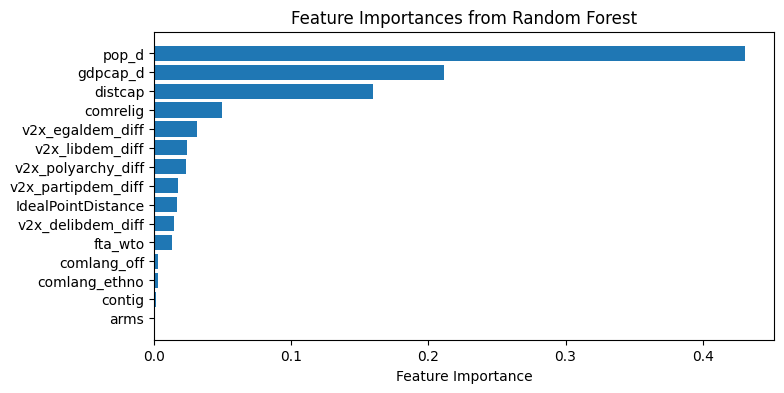

In [32]:
plt.figure(figsize=(8, 4))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel("Feature Importance")
plt.title("Feature Importances from Random Forest")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

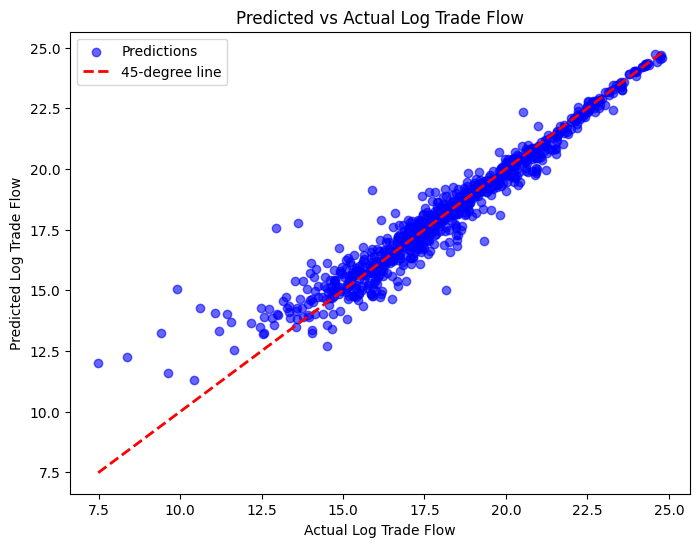

In [33]:
y_pred = best_model.predict(X_test)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='45-degree line')
plt.xlabel('Actual Log Trade Flow')
plt.ylabel('Predicted Log Trade Flow')
plt.title('Predicted vs Actual Log Trade Flow')
plt.legend()
plt.show()

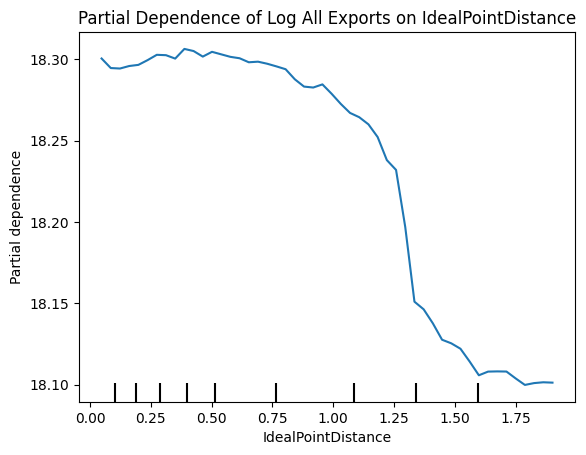

In [41]:
PartialDependenceDisplay.from_estimator(
    best_model,         # your fitted pipeline or model
    X_test,             # the dataset to evaluate on
    ['IdealPointDistance'],  # the feature(s) to plot
    grid_resolution=50,
)
plt.title("Partial Dependence of Log All Exports on IdealPointDistance")
plt.show()